In [1]:
# Allows code to live reload
%load_ext autoreload
%autoreload 2

## 1. Install
```sh
# Install prerequisites
pip install pyodc

```

## 2. Make an ECMWF account
- Go to ecmwf.int/, click login at the top right and click register to make a new account.
- Once logged in, go to api.ecmwf.int/v1/key/ to get your key. 
- Put it in `~/.ecmwfapirc` as directed.

In [2]:
# Load in the ECMWF token 
from pathlib import Path
import json
import requests
from IPython.display import JSON, display
from datetime import datetime as dt
from datetime import timedelta, timezone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

with open(Path("~/.ecmwfapirc").expanduser(), "r") as f:
    api_creds = json.load(f)

print("Checking API credentials")
r = requests.get(f"https://api.ecmwf.int/v1/who-am-i?token={api_creds['key']}")
if r.status_code == 403: print("Your credentials are either wrong or need to be renewed at https://api.ecmwf.int/v1/key/")
r.raise_for_status()
JSON(r.json())

Checking API credentials


<IPython.core.display.JSON object>

In [3]:
session = requests.Session()
session.headers["Authorization"] = f"Bearer {api_creds['key']}"

# API Endpoint

Documentation http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/docs

In [4]:
# url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"
url = "http://localhost:5002/api/v1/"

### Get all stations

In [5]:
%%time
from datetime import datetime

stations = session.get(url + "stations").json()
print(f"{len(stations) = }")

len(stations) = 3
CPU times: user 3 ms, sys: 1.35 ms, total: 4.35 ms
Wall time: 207 ms


In [6]:
stations[0]

{'name': 'Sede Comunale Moconesi',
 'description': 'An Acronet station',
 'platform': 'acronet',
 'external_id': 'sede_comunale_moconesi',
 'internal_id': '636e5a409d8ca7d7',
 'location': {'lat': 44.41948, 'lon': 9.212386},
 'time_span': {'start': '2025-01-06T11:39:00Z', 'end': '2025-01-06T11:44:00Z'},
 'authors': [{'name': 'acronet'}],
 'mars_request': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'chunked',
  'date': '20250106',
  'platform': 'acronet',
  'internal_id': '636e5a409d8ca7d7'}}

### Get stations with recent data

In [7]:
%%time
from datetime import datetime, timedelta, UTC

recent_stations = session.get(url + "stations", params = {
    "start_time" : datetime.now(UTC) - timedelta(hours = 3) 
}).json()
print(f"data ingested in last hour: {len(recent_stations) = }")

data ingested in last hour: len(recent_stations) = 3
CPU times: user 1.18 ms, sys: 804 μs, total: 1.99 ms
Wall time: 12.9 ms


In [8]:
granules = session.get(url + "list").json()
print(f"{len(granules) = }")

len(granules) = 20


In [9]:
from collections import Counter
types = Counter(s["platform"] for s in stations)
types

Counter({'acronet': 3})

In [10]:
from collections import defaultdict
by_platform = defaultdict(list)
for s in stations:
    by_platform[s["platform"]].append(s)

print("Most recently updated entry from each platform\n")
for platform, platform_stations in by_platform.items():
    if len(platform_stations) == 0: continue
    print(platform)
    print(json.dumps(
        sorted(platform_stations, key = lambda s : datetime.fromisoformat(s["time_span"]["end"]) )[-1],
    indent = 4))

Most recently updated entry from each platform

acronet
{
    "name": "Casa della Miniera",
    "description": "An Acronet station",
    "platform": "acronet",
    "external_id": "casa_della_miniera",
    "internal_id": "00d541a3ff24897b",
    "location": {
        "lat": 44.427803,
        "lon": 8.596518
    },
    "time_span": {
        "start": "2025-01-06T11:39:00Z",
        "end": "2025-01-06T12:19:00Z"
    },
    "authors": [
        {
            "name": "acronet"
        }
    ],
    "mars_request": {
        "class": "rd",
        "expver": "xxxx",
        "stream": "lwda",
        "aggregation_type": "chunked",
        "date": "20250106",
        "platform": "acronet",
        "internal_id": "00d541a3ff24897b"
    }
}


## Plot meteotracker time ranges

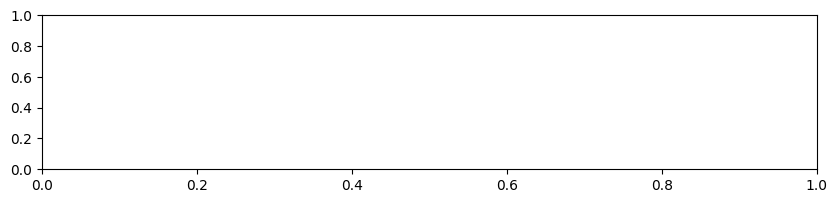

In [11]:
f, ax = plt.subplots(1, 1, figsize = (10, 2))

for station in by_platform["meteotracker"]:
    dt = datetime.fromisoformat(station["time_span"]["start"])
    d2 = datetime.fromisoformat(station["time_span"]["end"])
    ax.axvspan(dt, dt2, alpha = 0.01, color = "green")


## Obtain a whole meteotracker track

For meteotracker tracks it is sufficient to simply use the "mars_request" as a key to the retrieve endpoint (along with format=csv) to download the data.

In [12]:
from io import BytesIO

example_station = by_platform["meteotracker"][-1]

print(json.dumps(example_station["mars_request"], indent = 4))
granule_list = session.get(url + "list", params = example_station["mars_request"]).json()

print(f"The above MARS request matches {len(granule_list)} data granule(s).")

# Sanity check
assert len(granule_list) == 1

IndexError: list index out of range

## Get data as ODB and decode client side [Fastest]
This option allows the server the stream bytes straight from disk, all the other options require decoding to memory first.

In [ ]:
args = {
    "format" : "odb"
}

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)
data.raise_for_status()

df = None
try:
    import pyodc
    df = pyodc.read_odb(BytesIO(data.content), single = True)
except ImportError:
    print("pyodc not installed")
df

## Get data as JSON

In [ ]:
args = {
    "format" : "json"
}

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)
data.json()

## Get data as CSV

In [ ]:
args = {
    "format" : "csv"
}

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)

df = pd.read_csv(BytesIO(data.content))
df

In [ ]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)
geo_df.explore(column = "altitude")

## Obtain Stream data (Acronet, Smart Citizen Kit)

For the meteotracker data, each track is stored in a single data file. For continuous streams of data like the acronet stations, it is stored in 5 minute granules.

### Plot all Acronet stations in red and Smart Citizenkit in blue

In [ ]:
import folium

map = folium.Map(location=[44.226414, 9.532785], zoom_start=7)

for station in by_platform["acronet"]:
    p = station["location"]
    folium.CircleMarker(
        location=(station["location"]["lat"], station["location"]["lon"]),
        popup = station,
        radius=5, fill_color="orange", fill_opacity=0.4, color="black", weight=1,
    ).add_to(map)


for station in by_platform["smart_citizen_kit"]:
    folium.CircleMarker(
        location=(station["location"]["lat"], station["location"]["lon"]),
        popup = station,
        radius=5, fill_color="blue", fill_opacity=0.4, color="black", weight=1,
    ).add_to(map)
map

## Smart Citizen Kit

In [ ]:
example_station = by_platform["smart_citizen_kit"][-1]
example_station

## Choose retrieval time span 

In [ ]:
now = datetime.now()
args = {
    "start_time" : (now - timedelta(days = 1)).isoformat(),
    "end_time": (now - timedelta(hours = 0)).isoformat(),
}

## List data granules in span (optional)

In [ ]:
data_granules = session.get(url + "list", params = example_station["mars_request"]).json()
granules = [dict(date = g["mars_request"]["date"], time = g["mars_request"]["time"]) for g in data_granules]
granules[0]

## Retrieve data in span
This is one request rather than one per span

In [ ]:
data = session.get(url + "retrieve", params = example_station["mars_request"] | args | dict(format = "csv"))
df = pd.read_csv(BytesIO(data.content))
df

## Plot data for a few stations showing any missing granules

In [ ]:
now = datetime.now()
args = {
    "start_time" : (now - timedelta(hours = 12)).isoformat(),
    "end_time": (now - timedelta(hours = 0)).isoformat(),
}

n = len(by_platform["smart_citizen_kit"])
f, axes = plt.subplots(n, 1, figsize = (10, 2*n), sharex = True)

for ax, station in zip(axes, by_platform["smart_citizen_kit"]):
    granules = session.get(url + "list", params = station["mars_request"] | args).json()
    data = session.get(url + "retrieve", params = station["mars_request"] | args | dict(format = "csv"))
    df = pd.read_csv(BytesIO(data.content))
    df["datetime"] = pd.to_datetime(df["datetime"])

    df.plot(
    x = "datetime",
    y = "relative_humidity_near_surface",
    ax = ax, label = station["name"])
    
    for g in granules:
        date, time = g["mars_request"]["date"], g["mars_request"]["time"]
        dt = datetime.strptime(date + time, "%Y%m%d%H%M")
        dt2 = dt + timedelta(minutes = 5)
        # ax.axvline(dt, linestyle = "dotted", color = "green")
        # ax.axvline(dt2, linestyle = "dotted", color = "green")
        ax.axvspan(dt, dt2, alpha = 0.1, color = "green")

    # for d in example_station["time_span"]:
    #     ax.axvline(datetime.fromisoformat(d), linestyle = "dotted", color = "black")

    # ax.axvline(args["start_time"], linestyle = "dotted", color = "red")
    # ax.axvline(args["end_time"], linestyle = "dotted", color = "red")
    


print([dict(date = g["mars_request"]["date"], time = g["mars_request"]["time"]) for g in data_granules])
plt.tight_layout()
axes

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])

axes = df.plot(
    x = "datetime",
    y = ["relative_humidity_near_surface"],
    subplots=True, layout=(2, 1), figsize=(8, 4), sharex=True, rot=90)

for ax in axes[:, 0]:
    for g in granules:
        date, time = g["mars_request"]["date"], g["mars_request"]["time"]
        dt = datetime.strptime(date + time, "%Y%m%d%H%M")
        dt2 = dt + timedelta(minutes = 5)
        ax.axvline(dt, linestyle = "dotted", color = "green")
        ax.axvline(dt2, linestyle = "dotted", color = "green")
        ax.axvspan(dt, dt2, alpha = 0.1, color = "green")

    # for d in example_station["time_span"]:
    #     ax.axvline(datetime.fromisoformat(d), linestyle = "dotted", color = "black")

    ax.axvline(datetime.fromisoformat(args["start_time"]), linestyle = "dotted", color = "red")
    ax.axvline(datetime.fromisoformat(args["end_time"]), linestyle = "dotted", color = "red")
    


print([dict(date = g["mars_request"]["date"], time = g["mars_request"]["time"]) for g in data_granules])
plt.tight_layout()
axes[0, -1].get_xlim()

## Acronet

In [ ]:
[station["name"] for station in by_platform["acronet"]][:10] + [f"... {len(by_platform["acronet"])} in total"]

In [ ]:
from random import choice

example_station = choice(by_platform["acronet"])
example_station

### Data granules corresponging to an acronet station

In [ ]:
data_granules = session.get(url + "list", params = example_station["mars_request"]).json()
[dict(date = g["mars_request"]["date"], time = g["mars_request"]["time"]) for g in data_granules]

In [ ]:
import folium
p = (example_station["location"]["lat"], example_station["location"]["lon"])
map = folium.Map(location=p, zoom_start=13)

# Add the point as a marker
folium.Marker(
    location=p,
    popup = example_station,
).add_to(map)
map

Giving the "mars_request" to the `list` endpoint gives the list of data granules available from the list endpoint. For the acronet data and other continuous streams, there is an additional key "time" which gives the begining of the interval in the format HHMM

In the MARS system one needs to deal with these separate `date` and `time` fields but for convenience two special arguments are added to the API: `start_time` and `end_time`, these ISO formatted fields will be used to return data granules within the defined temporal region.

* If `start_time` or `end_time` are supplied, `date` and `time` are ignored. 
* If `start_time` or `end_time` fall within the boundary of a data chunk, the whole chunk will be returned.
* If only one of `start_time` or `end_time` are supplied, the other is ignored.
  
* If neither `start_time` nor `end_time` are supplied, `date` and `time` will be used following the typical MARS language.

The `list` endpoint is not necessary, but can be useful to retrieve the available chunks for a mars request. The arguments to `list` and `retrieve` are the same, list returns what data granules exist and `retrieve` returns the data granules concatenated together.

### Getting data for an acronet station

In [ ]:
example_station["mars_request"]

In [ ]:
now = datetime.now(UTC)

(now - timedelta(days = 7)).isoformat()

In [ ]:
%%time

from io import BytesIO
example_station = by_platform["acronet"][-1]
now = datetime.now(UTC)
args = {
    "start_time" : (now - timedelta(days = 7)).isoformat(),
    "end_time": (now - timedelta(hours = 0)).isoformat(),
}

granules = session.get(url + "list", params = example_station["mars_request"] | args).json()
data = session.get(url + "retrieve", params = example_station["mars_request"] | args | dict(format = "csv"))

df = pd.read_csv(BytesIO(data.content))
df

In [ ]:
df.columns

### Plot showing data granule boundaries and station time span along with data

Any missing granules will show up as white areas

- Green vertical lines: data granule boundaries
- Green shaded: places we have data
- Black vertical lines: Station time span
- Red vertical lines: User timespan request

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"])

axes = df.plot(
    x = "datetime",
    y = ["air_temperature_near_surface", "relative_humidity_near_surface"],
    subplots=True, layout=(2, 1), figsize=(8, 4), sharex=True, rot=90)

for ax in axes[:, 0]:
    for g in granules:
        date, time = g["mars_request"]["date"], g["mars_request"]["time"]
        dt = datetime.strptime(date + time, "%Y%m%d%H%M")
        dt2 = dt + timedelta(minutes = 5)
        ax.axvline(dt, linestyle = "dotted", color = "green")
        ax.axvline(dt2, linestyle = "dotted", color = "green")
        ax.axvspan(dt, dt2, alpha = 0.1, color = "green")

    for d in example_station["time_span"].values():
        ax.axvline(datetime.fromisoformat(d), linestyle = "dotted", color = "black")

    # ax.axvline(args["start_time"], linestyle = "dotted", color = "red")
    # ax.axvline(args["end_time"], linestyle = "dotted", color = "red")
    



plt.tight_layout()
axes[0, -1].get_xlim()